In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from chatsky_llm_autoconfig.settings import EnvSettings
env_settings = EnvSettings()
env_settings.RERANKER_MODEL

'BAAI/bge-reranker-v2-m3'

In [3]:
from datasets import load_dataset
%load_ext autoreload
%autoreload 2

from chatsky_llm_autoconfig.graph import BaseGraph, Graph
from chatsky_llm_autoconfig.schemas import DialogueGraph
from chatsky_llm_autoconfig.dialogue import Dialogue, DialogueMessage

from chatsky_llm_autoconfig.algorithms.three_stages_1 import ThreeStagesGraphGenerator as Generator
from chatsky_llm_autoconfig.algorithms.three_stages_1i import ThreeStagesGraphGenerator as GeneratorI
from chatsky_llm_autoconfig.algorithms.three_stages_0i import ThreeStagesGraphGenerator as GeneratorI0
from chatsky_llm_autoconfig.algorithms.append_chain import AppendChain

from langchain_openai import ChatOpenAI
from chatsky_llm_autoconfig.metrics.llm_metrics import are_triplets_valid
from chatsky_llm_autoconfig.metrics.automatic_metrics import all_utterances_present

/home/olshevskaya/miniconda3/envs/conda_env_py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


config.json:   0%|          | 0.00/795 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

In [ ]:
import matplotlib.pyplot as plt

In [50]:
graph_generator = Generator("o3-mini") # To generate 1st graph from one dialogue
graph_generator_llm_emb = GeneratorI() # To add dialogue to existing graph: adding nodes with LLM and edges with embedder
graph_generator_llm = GeneratorI0() # To add dialogue to existing graph with LLM
graph_generator_llm_2 = AppendChain() # To add (append) dialogue to existing graph with LLM (the second approach)

In [4]:
dataset = load_dataset("GEM/schema_guided_dialog", trust_remote_code=True)

# dialogues about rental cars
new_data=[]
topic = 'RentalCars_3'
for d in [el for el in dataset['test'] if el['service'] == topic]:
    exist = [[{'text':"Hello! How can I help you?", "participant":"assistant"}]] + [[{"text":u,"participant":"user"},{"text":a,"participant":"assistant"},] for u,a in zip(d['context'][0:-1:2],d['context'][1::2])] + [[{'text':d['prompt'], "participant":"user"}, {'text':d['target'], "participant":"assistant"}]]
    new_data.append([x for xs in exist for x in xs])
len(new_data)

932

Text(0.5, 1.0, 'length of one dialogue')

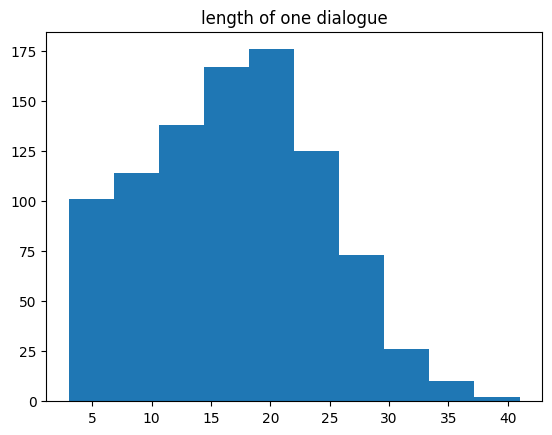

In [32]:
lens = [len(dia) for dia in new_data]
# length of one dialogue
plt.hist(lens)
plt.title('length of one dialogue')

Text(0.5, 1.0, 'length of one utterance')

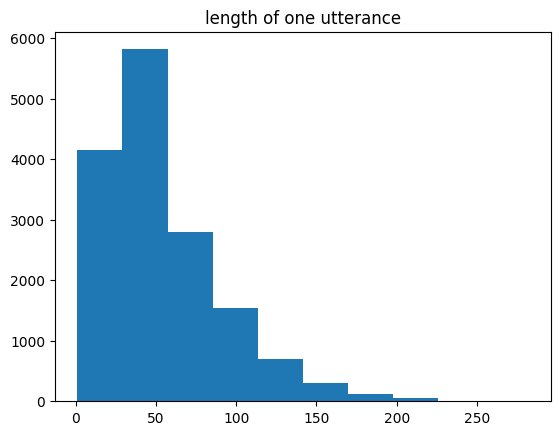

In [33]:
lens_uttr = [len(uttr['text']) for dia in new_data for uttr in dia]
# length of one utterance
plt.hist(lens_uttr)
plt.title('length of one utterance')

Pipeline:
1. select original dialogue
2. generate original graph based on original dialogue
3. select additional dialogue and add it to the original graph
4. validate result graph


In [ ]:
# select original dialogue, generate original graph
original_dialogue = [Dialogue.from_list(c) for c in new_data[:1]]
original_graph = graph_generator.invoke(original_dialogue)

In [ ]:
# validate original graph
all_utterances_present(original_graph, original_dialogue)

model = ChatOpenAI(name="gpt-3.5-turbo", temperature=0)
val_report = are_triplets_valid(original_graph, original_dialogue)
print(val_report)

original_graph.visualise_short("1 dialogue")

In [ ]:
# select additional dialogue
additional_dialogue = [Dialogue.from_list(c) for c in [new_data[1]]]
dialogues = original_dialogue + additional_dialogue

graph_generator_llm_emb


In [ ]:
# add additional dialogue to the original graph and validate it
result_graph_llm_emb, dialogues_ = graph_generator_llm_emb.invoke(additional_dialogue, original_graph)
all_utterances_present(result_graph_llm_emb, dialogues_)
val_report = are_triplets_valid(result_graph_llm_emb, dialogues)
print(val_report)

In [ ]:
result_graph_llm_emb.visualise_short("2 dialogues (result_graph_llm_emb)")

graph_generator_llm

In [ ]:
result_graph_llm = graph_generator_llm.invoke(additional_dialogue, original_graph)
all_utterances_present(result_graph_llm, dialogues)
val_report = are_triplets_valid(result_graph_llm, dialogues)
print(val_report)

In [ ]:
result_graph_llm.visualise_short("2 dialogues (result_graph_llm)")

graph_generator_llm_2

In [ ]:
result_graph_llm_2 = graph_generator_llm_2.invoke(dialogues, original_graph)
all_utterances_present(result_graph_llm_2, dialogues)
val_report = are_triplets_valid(result_graph_llm_2, dialogues)
print(val_report)

In [ ]:
result_graph_llm_2.visualise_short("2 dialogues (result_graph_llm_2)")


### Service functions

data is here - chatsky-llm-autoconfig/experiments/2025.01.22_sampler/data/

In [ ]:
def validate_graph(graph, dialogue_data, validation_model=ChatOpenAI(name="gpt-3.5-turbo", temperature=0)):
    val_report = {}
    val_report['all_utterances_present'] = all_utterances_present(graph, dialogue_data)
    val_report['are_triplets_valid'] = are_triplets_valid(graph, validation_model)
    return val_report

In [ ]:
def generate_graph_for_2_dialogues(
        first_graph_generator, second_graph_generator, dialogues, vis=True
        ):
    original_dialogue, additional_dialogue = [dialogues[0]], [dialogues[1]]

    # generate original graph
    try:
        print('Original graph generation...')
        original_graph = first_graph_generator.invoke(original_dialogue)

        if vis:
            original_graph.visualise_short("2 original_graph")
        # validate original graph
        print(validate_graph(original_graph, original_dialogue))

    except Exception as e:
        print(e)

    # add additional dialogue to the original graph
    try:
        print('Adding additional dialogue to the original graph...')
        if second_graph_generator == GeneratorI():
            result_graph, dialogues_ = second_graph_generator.invoke(additional_dialogue, original_graph)
        elif second_graph_generator == GeneratorI0():
            result_graph = second_graph_generator.invoke(additional_dialogue, original_graph)
        elif second_graph_generator == AppendChain():
            result_graph = second_graph_generator.invoke(dialogues, original_graph)

        if vis:
            result_graph.visualise_short("2 dialogues")
        # validate result graph
        val_report = validate_graph(result_graph, dialogues)
        
        return result_graph, val_report

    except Exception as e:
        print(e)

In [ ]:
#for example
result_graph, val_report = generate_graph_for_2_dialogues(
    Generator("o3-mini"), GeneratorI(), dialogues, original_graph, vis=True
    )
print(val_report)